In [201]:
# Import basic
import pandas as pd
import numpy as np
import cv2
# Import plots
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# from keras.models import Sequential
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.models import model_from_json, Model, Sequential, load_model
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM, Dense
from keras.layers.wrappers import TimeDistributed

from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger
from importlib import reload
import visualization
import transformations
import model
import loader
import matplotlib.pyplot as plt
from visualization import plots, hist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

## Sample images from Polysync

I did not perform any preprocessing on the images except for scaling. I read in 320x160 images and resize it to 160x80. I experimented on different images size and found out that scaling the images down did not reduce the performance of our regression.

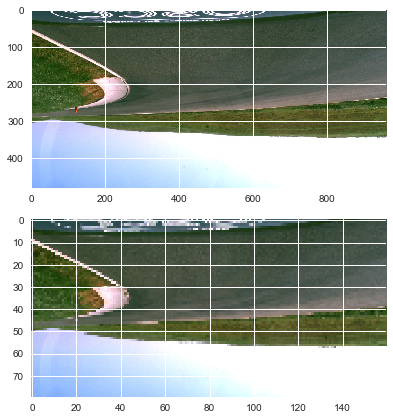

In [340]:
## import config
reload(loader)
reload(config)
reload(transformations)
from loader import *
from config import *
from transformations import *
ROOT = '/Users/nando/Desktop/thunderhill-day1-data'
OUTPUT = '.'

def getDataFromThunderhill(folder, output, normalize=False, randomize=True, balance=False, split=True):
    data = pd.DataFrame(columns=COLUMNS)
    for csvpath in glob.glob('{}/**/output_accel.txt'.format(folder)):
        df = pd.read_csv(csvpath)
        df = df.dropna(axis=0)
        skip = False
        for toSkip in SKIP:
            if toSkip in csvpath:
                skip = True
        if skip:
            continue
        basename = os.path.dirname(csvpath)
        df['center'] = basename + '/' + df['path']
        df['speed'] = np.power(np.power(df['vel0'], 2) + np.power(df['vel0'], 2) + np.power(df['vel0'], 2), 0.5)
        mask = df['accel']>-0.2
        df.loc[mask, 'throttle'] = df[mask]['accel'] + 0.2
        data = data.append(df, ignore_index=True)
    
    if balance:
        # data = data.where(data['steering'] != 0).dropna(axis=0)
        zeros = data.where(data['steering'] == 0).dropna(axis=0).sample(1000)
        non_zeros = data.where(data['steering'] != 0).dropna(axis=0)
        data = zeros.append(non_zeros)

    if randomize:
        data = shuffle(data)

    if normalize:
        scaler = StandardScaler()
        data[COLUMNS_TO_NORMALIZE] = scaler.fit_transform(data[COLUMNS_TO_NORMALIZE])
    if split:
        return train_test_split(data, test_size=0.2, random_state=42)
    return data

def ReadImg(path):
    img = np.array(cv2.cvtColor(cv2.imread(path.strip()), code=cv2.COLOR_BGR2RGB))
    if '320x160' in path:
        img = img[20:140, :, :]
    return img

df_train = getDataFromThunderhill(ROOT, OUTPUT, randomize=False, balance=False, split=False)
img = ReadImg(df_train['center'][1000])
pimg = Preproc(img)
plots([img, pimg])

## Data augmentation
In my keras generator, I augment the dataset by applying random affine transfromations such as:
- Random rotation between -15 and 15
- Random shift between -5 to 5 pixels
- Random brightness
- Random flip
- Random brightness

Flipping the images double the sizes of the training set.

## Architecture

I extract the features from the images using the CNN layers of the NVIDIA model. Then, feed the extracted features from the images + speed to a fully connected network to predict the <steering-angle; throttle; brake> using RMSE. 


    Images           Speed
      |                |
      
      |                |
      
CNN(24, 5, 5)          

      |                |
      
CNN(36, 5, 5)          

      |                |
      
CNN(64, 3, 3)          

      |                |
      
CNN(64, 3, 3)          
      |                |
      ------------------
             |
     Batch Normalization
             | 
          FC(100)
             | 
           FC(50)    
             |
           FC(10)
             |
             |
      ----------------------     
     |             |        |
     steering    brake    throttle
     
It's important to note that I did not normalize the speed; instead I added a batch normalization layer before the fully connected layer.

In [333]:
df_train['speed'] = np.power(np.power(df_train['vel0'].astype(float), 2) + np.power(df_train['vel1'].astype(float), 2) + np.power(df_train['vel2'].astype(float), 2), 0.5)
df_train[['brake', 'steering', 'speed', 'vel0', 'vel1', 'vel2', 'throttle']].describe()

,brake,steering,speed,vel0,vel1,vel2,throttle
count,35809.000000,35809.000000,35809.000000,35809.000000,35809.000000,35809.000000,35809.000000
mean,0.073887,0.019276,20.163219,-0.410187,-0.639349,-0.007355,0.208114
std,0.154494,0.077934,5.147969,12.891529,16.308571,0.574665,0.086384
min,0.000000,-0.279253,0.000000,-27.710602,-32.523182,-2.071563,0.000000
25%,0.018311,-0.022689,16.433316,-10.461619,-15.102164,-0.396708,0.168297
50%,0.018311,0.003491,20.025008,-1.747157,0.588814,0.120720,0.215327
75%,0.018311,0.068068,23.789745,10.445411,14.549524,0.323044,0.261747
max,1.739502,0.387463,33.706074,28.605457,29.633589,1.644871,0.527708


## Histogram of steering, histogram, and brake

Looking at the steering's histogram, the data bias toward 0. To balance out the data, we weighted samples by undersampling the steering angle around zero and recording few laps of recovery data.

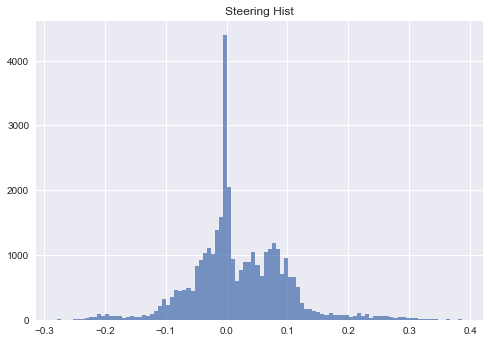

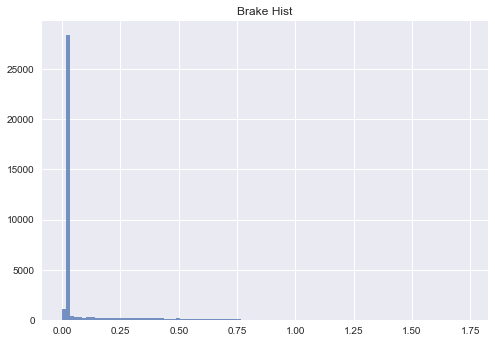

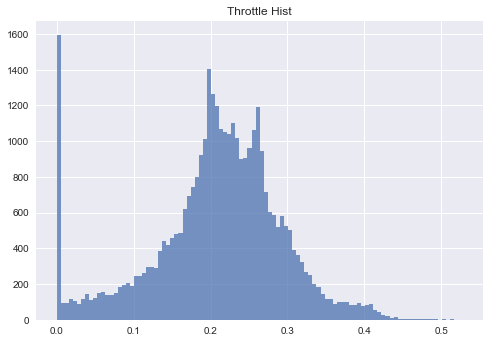

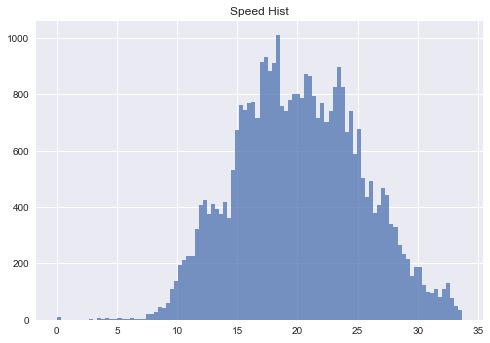

In [335]:
reload(visualization)
from visualization import hist
hist(df_train, 'steering', title='Steering Hist')
hist(df_train, 'brake', title='Brake Hist')
hist(df_train, 'throttle', title='Throttle Hist')
hist(df_train, 'speed', title='Speed Hist')

## Random scatter plot of features

I am plotting a scatter plot of all the features hoping to visualize the relationships between them if any.

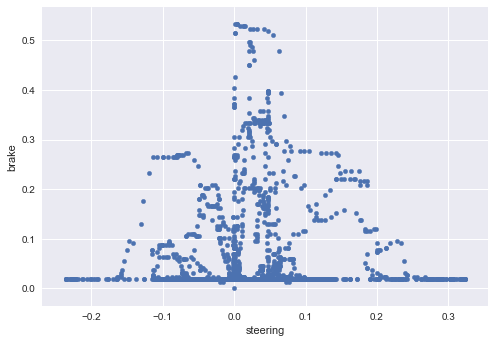

In [165]:
df_train.plot.scatter(x='steering', y='brake')
plt.show()

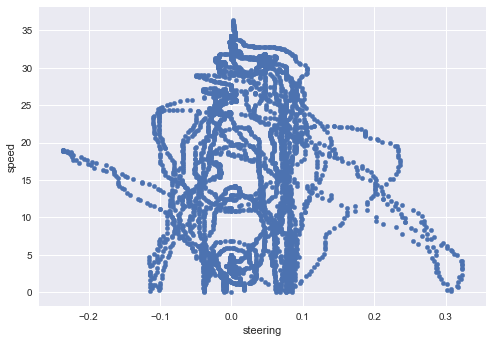

In [166]:
df_train.plot.scatter(x='steering', y='speed')
plt.show()

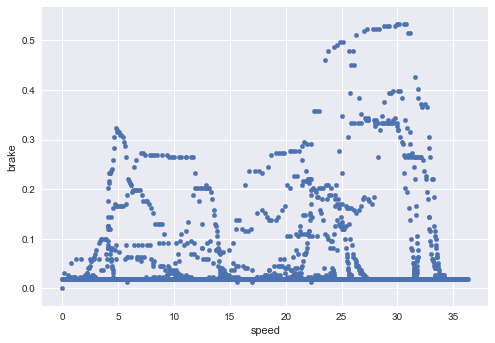

In [167]:
df_train.plot.scatter(x='speed', y='brake')
plt.show()

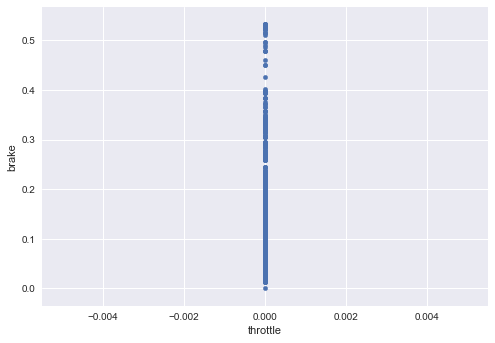

In [168]:
df_train.plot.scatter(x='throttle', y='brake')
plt.show()

## Results

This approach did not work because I relied on the simulator data and few laps around the thunderhill track. 

To address the issue:
- I'll try to train the model on Udacity's self driving car challenge here  https://github.com/udacity/self-driving-car Then, fine tune it on the thunderhill track. Alternatively, I'll try use the ImageNet to fine tune the model. 
- I'll also add the PosNet approach described here (https://github.com/teamsoulless/thunderhill/tree/master/models/nando/nvidia_posnet) in addition.